In [1]:
from myFunctions import *

/Users/yingcheng/miniconda3/envs/oct2023/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
df['1332 JT']

,last,volume
date,,
2013-01-04,169.0987,1464100
2013-01-07,166.3266,1783500
2013-01-08,166.3266,1759800
2013-01-09,165.4026,767800
2013-01-10,167.2507,1503100
...,...,...
2021-03-15,560.0000,1537500
2021-03-16,559.0000,1594200
2021-03-17,561.0000,1328200


Attempt to use GRU Model to predict price signals using last price and volume

- train on a single time series and evaluate on whole dataset

In [3]:
df['1332 JT'].head()

columns = ['last', 'volume']
data = df['1332 JT'][columns]
data.head()


,last,volume
date,,
2013-01-04,169.0987,1464100
2013-01-07,166.3266,1783500
2013-01-08,166.3266,1759800
2013-01-09,165.4026,767800
2013-01-10,167.2507,1503100


In [4]:
scaler = MinMaxScaler()
scaler.fit(data[data.columns])
data[data.columns] = scaler.transform(data[data.columns])

data

,last,volume
date,,
2013-01-04,0.015168,0.013904
2013-01-07,0.011031,0.018952
2013-01-08,0.011031,0.018577
2013-01-09,0.009652,0.002899
2013-01-10,0.012410,0.014520
...,...,...
2021-03-15,0.598496,0.015064
2021-03-16,0.597004,0.015960
2021-03-17,0.599989,0.011756


In [5]:
def preprocess_data(df, window = 15):
    df_as_np = df.to_numpy()

    X = []
    y = []

    # Iterate through the array, adding the window of values to X and the corresponding label to y
    for i in range(len(df_as_np)-window):
        row = [r for r in df_as_np[i:i+window]]
        X.append(row)
        label = df_as_np[i+window][0]
        y.append(label)

    # Return x,y as np arrays
    return np.array(X), np.array(y)

In [6]:
X, y = preprocess_data(data)
print(f'X shape {X.shape} y shape {y.shape}')
print(f'There are {X.shape[0]} samples, {X.shape[1]} timesteps and {X.shape[2]} features in the our data')

X shape (1990, 15, 2) y shape (1990,)
There are 1990 samples, 15 timesteps and 2 features in the our data


In [7]:
y = np.squeeze(scaler.fit_transform(np.expand_dims(y, axis=1)))
y

array([0.01378913, 0.01378913, 0.01654698, ..., 0.59998872, 0.60595778,
       0.60894231])

Train-test split

In [32]:
#Setting the threshold for splitting the data 
threshold = int(X.shape[0] * 0.8)  # 75% of data for training

# 75% of data for training
X_train, y_train = X[:threshold], y[:threshold]

# 25% of data for testing
X_test, y_test = X[threshold:], y[threshold:]

# Print shapes of training and testing sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1592, 15, 2)
y_train shape: (1592,)
X_test shape: (398, 15, 2)
y_test shape: (398,)


Simple GRU model is utilized since performance is not necessarily the focus here

In [47]:
early_stop=EarlyStopping(monitor='val_loss', patience=10, verbose=0)

def build_model():
    model = Sequential()
    model.add(InputLayer((X_train.shape[1], X_train.shape[2])))
    # model.add(GRU(416,return_sequences=True))
    # model.add(GRU(640,return_sequences=True))
    # model.add(GRU(960, return_sequences=True))
    model.add(GRU(100))
    model.add(Dense(8, 'relu'))
    model.add(Dense(1, activation="linear"))

    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
    
    return model

model = build_model()

In [48]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, callbacks=early_stop)

Epoch 1/100


2023-09-25 21:17:23.178336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-25 21:17:23.319083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-25 21:17:23.872087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.0013

2023-09-25 21:17:24.965556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-25 21:17:25.014463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 3s 24ms/step - loss: 0.1057 - accuracy: 0.0013 - val_loss: 0.0191 - val_accuracy: 0.0000e+00
Epoch 2/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0194 - accuracy: 0.0013 - val_loss: 0.0174 - val_accuracy: 0.0000e+00
Epoch 3/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0142 - accuracy: 0.0013 - val_loss: 0.0171 - val_accuracy: 0.0000e+00
Epoch 4/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0172 - accuracy: 0.0013 - val_loss: 0.0170 - val_accuracy: 0.0000e+00
Epoch 5/100
50/50 [==============================] - 1s 12ms/step - loss: 0.0147 - accuracy: 0.0013 - val_loss: 0.0166 - val_accuracy: 0.0000e+00
Epoch 6/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0160 - accuracy: 0.0013 - val_loss: 0.0192 - val_accuracy: 0.0000e+00
Epoch 7/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0145 - accuracy: 0.0013 - val_loss: 0.0158 - val_accuracy: 0

In [70]:
test_predictions = model.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})

13/13 [==============================] - 0s 5ms/step


Text(0.5, 0, 'Time')

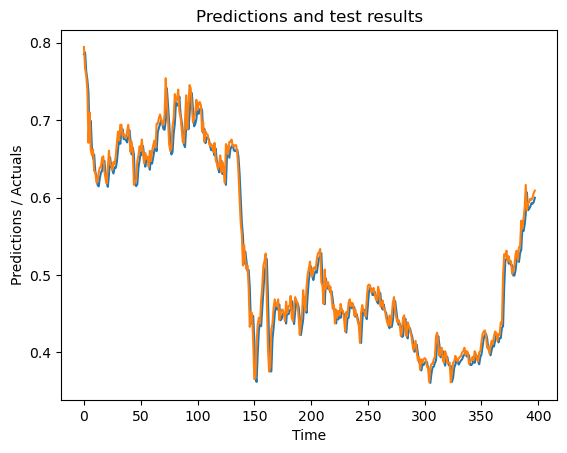

In [52]:
plt.plot(test_results['Test Predictions']) 
plt.plot(test_results['Actuals'])
plt.title('Predictions and test results')
plt.ylabel('Predictions / Actuals')
plt.xlabel('Time')

In [53]:
from sklearn.metrics import mean_squared_error

In [54]:
print('MSE of the GRU model :', round(mean_squared_error(test_results['Test Predictions'], test_results['Actuals']),6))

MSE of the GRU model : 0.000312


Using this model, predict price signals for 'JT 1332' in the dataset

In [95]:
jt = df['1332 JT']
columns = ['last', 'volume']
data = jt[columns]
scaler = MinMaxScaler()
scaler.fit(data[data.columns])
data[data.columns] = scaler.transform(data[data.columns])

X,y = preprocess_data(data)
y = np.squeeze(scaler.fit_transform(np.expand_dims(y, axis=1)))
predicted_prices = model.predict(X).flatten()
# predicted_prices = scaler.inverse_transform(np.hstack((X, predicted_prices.reshape(-1, 1))))[:, -1]

signals = []
for i in range(len(predicted_prices)):
    current_price = data.iloc[i + 15]['last']
    predicted_price = predicted_prices[i]

    if predicted_price > current_price:
        signal = 1
    elif predicted_price < current_price:
        signal = -1
    else:
        signal = 0

    signals.append(signal)

# Print the signals
print(signals)
    

27/63 [===========>..................] - ETA: 0s

/var/folders/43/n044fj2j5w1b2wvl87r80rj80000gn/T/ipykernel_50534/3581476771.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data.columns] = scaler.transform(data[data.columns])


63/63 [==============================] - 0s 4ms/step
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1,

In [96]:
jt['Signal'] = 0
jt.loc[jt.index[15:], 'Signal'] = signals
jt

,last,volume,Signal,return,position,strategy_returns
date,,,,,,
2013-01-04,169.0987,1464100,0,NaN,NaN,NaN
2013-01-07,166.3266,1783500,0,-0.016529,0.0,-0.000000
2013-01-08,166.3266,1759800,0,0.000000,0.0,0.000000
2013-01-09,165.4026,767800,0,-0.005571,0.0,-0.000000
2013-01-10,167.2507,1503100,0,0.011111,0.0,0.000000
...,...,...,...,...,...,...
2021-03-15,560.0000,1537500,-1,0.005372,-1.0,-0.005372
2021-03-16,559.0000,1594200,-1,-0.001787,-1.0,0.001787
2021-03-17,561.0000,1328200,-1,0.003571,-1.0,-0.003571


In [97]:
# implement position and calculate returns
jt['return'] = np.log(jt['last']/jt['last'].shift(1))
jt['position'] = jt['Signal'].replace(to_replace=0, method='ffill')
jt['position'] = jt['position'].shift(1)
jt['strategy_returns'] = jt['return'] * (jt['position'])

Cumulative returns for 'JT 1332'

In [98]:
jt['strategy_returns'].cumsum().iloc[-1]

1.5101467723634776

Run on all tickers in the dataset

In [101]:
for k,v in df.items():

    jt = v.copy()
    columns = ['last', 'volume']
    data = jt[columns]
    scaler = MinMaxScaler()
    scaler.fit(data[data.columns])
    data[data.columns] = scaler.transform(data[data.columns])

    X,y = preprocess_data(data)
    y = np.squeeze(scaler.fit_transform(np.expand_dims(y, axis=1)))
    predicted_prices = model.predict(X).flatten()

    signals = []
    for i in range(len(predicted_prices)):
        current_price = data.iloc[i + 15]['last']
        predicted_price = predicted_prices[i]

        if predicted_price > current_price:
            signal = 1
        elif predicted_price < current_price:
            signal = -1
        else:
            signal = 0

        signals.append(signal)

    # insert new column
    jt['Signal'] = 0
    jt.loc[jt.index[15:], 'Signal'] = signals
    jt['return'] = np.log(jt['last']/jt['last'].shift(1))
    jt['position'] = jt['Signal'].replace(to_replace=0, method='ffill')
    jt['position'] = jt['position'].shift(1)
    jt['strategy_returns'] = jt['return'] * (jt['position'])

    df[k] = jt


26/63 [===========>..................] - ETA: 0s

/var/folders/43/n044fj2j5w1b2wvl87r80rj80000gn/T/ipykernel_50534/3749492474.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data.columns] = scaler.transform(data[data.columns])


63/63 [==============================] - 0s 4ms/step


In [105]:
def evaluate_strat(df):

    res = {}
    for k,v in df.items():
        avg_return = np.mean(v['strategy_returns'])
        std_return = np.std(v['strategy_returns'])
        sharpe_ratio = (avg_return - rfr) / std_return

        sortino_ratio = calculate_sortino_ratio(v['strategy_returns'], rfr)
        
        max_drawdown = calculate_max_drawdown(v['strategy_returns'])

        skewness = v['strategy_returns'].skew()
        kurt = v['strategy_returns'].kurtosis()

        res[k] = {
            'Cumulative Returns': v['strategy_returns'].cumsum().iloc[-1],
            'Sharpe_Ratio': sharpe_ratio,
            'Max_Drawdown': max_drawdown,
            'Sortino_Ratio': sortino_ratio,
            'Skewness': skewness,
            'Kurtosis': kurt
        }

    metrics_df = pd.DataFrame.from_dict(res, orient = "index")
    avg_df = metrics_df.mean()
    print(avg_df)
    return res

evaluate_strat(df)

Cumulative Returns   -0.343972
Sharpe_Ratio         -1.002144
Max_Drawdown         -0.693190
Sortino_Ratio        -1.185507
Skewness             -0.083628
Kurtosis              5.302650
dtype: float64


{'1332 JT': {'Cumulative Returns': 1.5101467723634776,
  'Sharpe_Ratio': -0.8776146185882435,
  'Max_Drawdown': -0.5523917714850671,
  'Sortino_Ratio': -1.0936193605740694,
  'Skewness': 0.25805632415985064,
  'Kurtosis': 7.061491569312523},
 '1333 JT': {'Cumulative Returns': 0.6515070589706203,
  'Sharpe_Ratio': -1.1945006411729173,
  'Max_Drawdown': -0.5341754020264076,
  'Sortino_Ratio': -1.3687883155286107,
  'Skewness': -0.08717279658175586,
  'Kurtosis': 4.4438711682652485},
 '1334 JT': {'Cumulative Returns': 0.9384182339686866,
  'Sharpe_Ratio': -0.978763774009899,
  'Max_Drawdown': -0.24527485516093006,
  'Sortino_Ratio': -1.1597562037024856,
  'Skewness': -0.13362958452583126,
  'Kurtosis': 3.053126185980744},
 '1605 JT': {'Cumulative Returns': -0.6896909699419129,
  'Sharpe_Ratio': -0.9398532061240827,
  'Max_Drawdown': -0.7899197109136655,
  'Sortino_Ratio': -1.102900169906551,
  'Skewness': -0.3188923285121661,
  'Kurtosis': 3.4288527093219927},
 '1721 JT': {'Cumulative Ret

Conclusion

It appears that the strategy did not perform well after being backtested on all 248 tickers/time series. This is expected as the GRU model was a fairly simple one and hyperparameter optimisation was not performed. Furthermore, the model was only trained on a single time series selected among the 248. Ideally, the model should be trained on as many time series as possible. After comparing the various statistics listed, we can conclude that the strategy implemented was actually worse than the "Buy & hold strategy" and Bollinger Bands as well. 